# Purpose

Create Topic model from DOCS

# Setup

## Import

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import plotly.express as px
import nltk

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Config

In [3]:
ngram_range = (1,2)
n_terms = 4000
n_topics = 9
# n_topics = 20
max_iter = 20
n_top_terms = 9

customize

In [4]:
colors = "YlGnBu"
data_in = '/Users/Lingmin/Desktop'
data_prefix = 'Patent_project'
BAG = ['doc_id']

should import TOKENS

In [5]:
#DOCS = pd.read_pickle(f'{data_in}/{data_prefix}/patents.pickle')
#DOCS = DOCS[DOCS['year_y'] == 1997]
#DOCS = DOCS.drop('year_y', axis = 1)
#DOCS.columns = ['doc_str']

# Prepare data

## Create DOCS from TOKENS

In [6]:
TOKENS = pd.read_pickle(f'{data_in}/{data_prefix}/data/TOKENS.pickle')

DOCS = TOKENS[TOKENS.pos.str.match(r'^NNS?$')]\
    .groupby(BAG).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})

## Filter for Nouns

In [7]:
def f(text):
    global sw
    new_text = ' '.join([word for word in text.split() if word not in sw])
    return new_text


In [8]:
sw = nltk.corpus.stopwords.words('english')+[' ']+['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten']\
+['fig','figure','figures','description','definition','detailed']

In [9]:
DOCS['doc_str'] = DOCS.apply(lambda x: f(x['doc_str']), axis = 1)

In [10]:
DOCS

,doc_str
doc_id,
5590665,embodiments network error propagation algorith...
5590908,embodiments embodiments invention modification...
5591432,invention antibody becton dickinson biology sa...
5592173,invention block diagram embodiment gps receive...
5592402,embodiments method invention set multivariate ...
...,...
5704015,embodiments reference drawings embodiments inv...
5704016,embodiments embodiment invention reference dra...
5704017,invention embodiment invention collaborative f...


## Create Vector Space

In [11]:
count_engine = CountVectorizer(max_features=n_terms, ngram_range=ngram_range, stop_words='english')
count_model = count_engine.fit_transform(DOCS.doc_str)
TERMS = count_engine.get_feature_names_out()

In [12]:
VOCAB = pd.DataFrame(index=TERMS)
VOCAB.index.name = 'term_str'

In [13]:
DTM = pd.DataFrame(count_model.toarray(), index=DOCS.index, columns=TERMS)

In [14]:
VOCAB['doc_count'] = DTM.astype('bool').astype('int').sum()
DOCS['term_count'] = DTM.sum(1)

# Generate Model

In [15]:
lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

## Topic names

In [16]:
TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]

## Theta

In [17]:
lda_model = lda_engine.fit_transform(count_model)

In [18]:
THETA = pd.DataFrame(lda_model, index=DOCS.index)
THETA.columns.name = 'topic_id'
THETA.columns = TNAMES


In [19]:
THETA.sample(20).style.background_gradient(cmap=colors, axis=None)

,T0,T1,T2,T3,T4,T5,T6,T7,T8
doc_id,,,,,,,,,
5598511,0.000086,0.999312,0.000086,0.000086,0.000086,0.000086,0.000086,0.000086,0.000086
5611020,0.000056,0.397362,0.000056,0.000056,0.305618,0.000056,0.000056,0.000056,0.296685
5700204,0.001893,0.023930,0.083215,0.020845,0.000033,0.002666,0.864705,0.002679,0.000033
5612908,0.284308,0.019775,0.127370,0.029277,0.000074,0.000074,0.000074,0.518630,0.020418
5664066,0.000068,0.041945,0.026342,0.152575,0.022509,0.082287,0.447750,0.024382,0.202142
5619537,0.006577,0.000070,0.000070,0.138932,0.000070,0.123515,0.460029,0.270666,0.000070
5677694,0.000195,0.000195,0.081905,0.379964,0.000195,0.082182,0.454974,0.000195,0.000195
5691729,0.000103,0.057876,0.324542,0.054059,0.000103,0.000103,0.443855,0.000103,0.119257
5604895,0.000022,0.728188,0.023908,0.158908,0.000022,0.045877,0.000022,0.043032,0.000022


## Phi

In [20]:
PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
PHI.index.name = 'topic_id'
PHI.columns.name  = 'term_str'

In [21]:
PHI.T.sample(20).style.background_gradient(cmap=colors, axis=None)

topic_id,T0,T1,T2,T3,T4,T5,T6,T7,T8
term_str,,,,,,,,,
treatment,0.111123,0.111248,0.111245,0.111147,303.632697,0.111155,132.222402,61.135079,3.453904
constraint graph,0.111111,0.111121,0.111117,0.111112,0.111111,0.111116,0.111111,79.111082,0.111118
exposure,0.111112,0.111154,6.656027,0.111166,32.137071,1.281789,280.369273,0.111175,0.111232
following,4.746857,117.179315,0.111166,9.026607,6.208423,34.305894,35.705041,8.605547,0.111148
sum,95.730255,52.998953,0.111190,402.331400,0.531180,386.735226,221.480482,219.007141,271.074173
shot,0.111122,0.111165,0.111149,22.312510,150.159800,0.111181,86.860665,0.111153,0.111254
molecule,0.111111,0.111115,0.111113,0.111112,410.111056,0.111124,0.111124,0.111123,0.111123
horizontal,0.111149,0.111182,32.057521,2.530209,0.111132,9.264956,20.063224,10.876617,10.874011
illustration,13.175580,53.688854,40.066657,44.056451,15.654679,44.127742,65.275689,27.424160,34.530188


# Inspect Results
## Create TOPICS and get Top Terms per Topic

In [22]:
TOPICS = PHI.stack().to_frame('topic_weight').groupby('topic_id')\
    .apply(lambda x: x.sort_values('topic_weight', ascending=False)\
        .head(n_top_terms).reset_index().drop('topic_id', axis=1)['term_str'])


In [23]:
TOPICS

term_str,0,1,2,3,4,5,6,7,8
topic_id,,,,,,,,,
T0,data,engine,bit,association,instruction,register,association engine,input,bits
T1,data,step,user,information,test,example,block,invention,process
T2,voltage,channel,circuit,cell,power,transistor,device,gate,line
T3,output,input,signal,circuit,data,memory,value,signals,control
T4,cells,sequence,cell,example,dna,protein,type,data,acid
T5,sub,vector,step,value,input,number,data,speech,training
T6,sub,time,value,model,control,invention,values,data,function
T7,sub,sub sub,sup,line,sub sup,sup sub,equ,delta,equation
T8,image,network,data,layer,input,neurons,neuron,output,sub


In [24]:
TOPICS['label'] = TOPICS.apply(lambda x: x.name + ' ' + ', '.join(x[:n_top_terms]), 1)

In [25]:
labels  = TOPICS.label.tolist()

<Figure size 640x480 with 0 Axes>

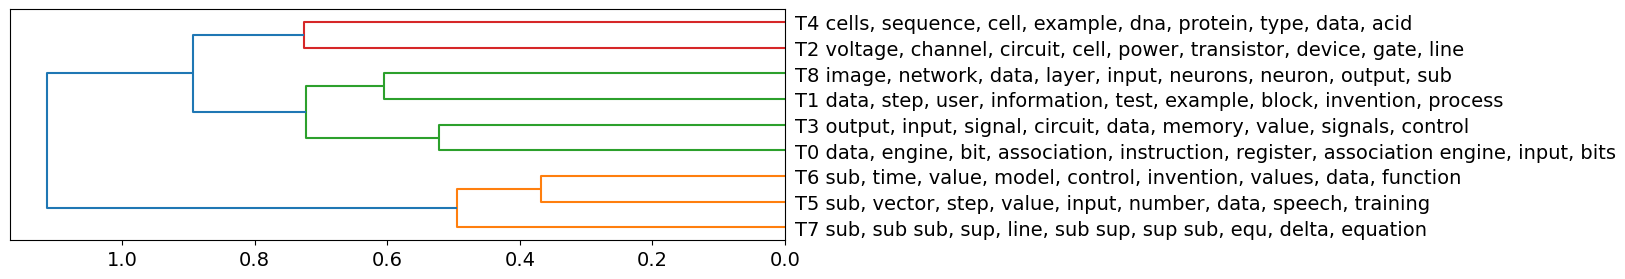

In [26]:
import plotly.figure_factory as ff
from plotly.figure_factory import create_dendrogram # Built on top SciPy

import sys
sys.path.append("/Users/Lingmin/Desktop/Patent_project/lib")

from hac import HAC

HAC(PHI, labels=labels).plot();

In [27]:
HAC(THETA.drop('class',axis = 1).T, labels=labels).plot()

KeyError: "['class'] not found in axis"

## Compare with true label

In [ ]:
cpc = pd.read_csv(f"{data_in}/{data_prefix}/g_cpc_current.tsv", sep='\t')

In [ ]:
cpc = cpc.drop_duplicates(subset = ['patent_id'], keep = 'first')

In [ ]:
THETA['class'] = THETA.idxmax(axis=1)

THETA.index = THETA.index.astype('int')

In [ ]:
compare = pd.merge(THETA[['class']], cpc, left_on = 'doc_id', right_on = 'patent_id', how = 'left')

In [ ]:
PD=compare.groupby('cpc_section')['class'].value_counts().unstack().fillna(0)

In [ ]:
PD['total_patent']=PD.sum(axis=1)
PD['max_group']=PD.loc[:, PD.columns != 'total_patent'].max(axis=1)
PD['rate']=PD.max_group/PD.total_patent

In [ ]:
PD

In [ ]:
PD.rate.mean()

# Save

In [ ]:
path = '/Users/Lingmin/Desktop/Patent_project/data'

THETA.to_pickle(path + '/THETA.pickle')
PHI.to_pickle(path + '/PHI.pickle')
THETA.to_csv(path + '/THETA.csv')
PHI.to_csv(path + '/PHI.csv')

In [ ]:
PHI